# LSTM For Predictive Maintenance

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

### Loading Dataset

In [2]:
dataset_train=pd.read_csv('data/train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
dataset_test=pd.read_csv('data/test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names
print('Shape of Test dataset: ',dataset_test.shape)
dataset_test.head()

Shape of Test dataset:  (13096, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


#### Loading Truth table

In [4]:
pm_truth=pd.read_csv('data/truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more']
pm_truth['id']=pm_truth.index+1
pm_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [5]:
# generate column max for test data
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [6]:
# run to failure
pm_truth['rtf']=pm_truth['more']+rul['max']
pm_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [7]:
pm_truth.drop('more', axis=1, inplace=True)
dataset_test=dataset_test.merge(pm_truth,on=['id'],how='left')
dataset_test['ttf']=dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)
dataset_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [8]:
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max)-dataset_train['cycle']
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:
df_train=dataset_train.copy()
df_test=dataset_test.copy()
period=30
df_train['label_bc'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label_bc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [10]:
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name='label_bc'

## Feature Scaling

In [11]:
sc=MinMaxScaler()
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])

## Function to reshape dataset as required by LSTM

In [12]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [13]:
# timestamp or window size
seq_length=50
seq_cols=features_col_name

In [14]:
# generate X_train
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['id']==id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)
# generate y_train
y_train=np.concatenate(list(list(gen_label(df_train[df_train['id']==id], 50, seq_cols,'label_bc')) for id in df_train['id'].unique()))
print(y_train.shape)

(20531, 50, 24)
(20531,)


In [15]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['id']==id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)
# generate y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['id']==id], 50, seq_cols,'label_bc')) for id in df_test['id'].unique()))
print(y_test.shape)

(12996, 50, 24)
(12996,)


## LSTM Network

In [16]:
nb_features =X_train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50000     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fit the network
model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
98/98 [==============================] - 28s 223ms/step - loss: 0.1737 - accuracy: 0.9324 - val_loss: 0.0549 - val_accuracy: 0.9854
Epoch 2/10
98/98 [==============================] - 22s 225ms/step - loss: 0.0777 - accuracy: 0.9667 - val_loss: 0.0468 - val_accuracy: 0.9825


In [18]:
# training metrics
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]*100), "%")

103/103 [==============================] - 8s 76ms/step - loss: 0.0621 - accuracy: 0.9736
Accurracy: 97.36496210098267 %


In [19]:
#y_pred=model.predict_classes(X_test)

y_pred=model.predict(X_test) 
classes_x=np.argmax(y_pred,axis=1)
y_true = y_train
print('Accuracy of model on test data: ',accuracy_score(y_test,classes_x))
print('Confusion Matrix: \n',confusion_matrix(y_test,classes_x))

Accuracy of model on test data:  0.9744536780547861
Confusion Matrix: 
 [[12664     0]
 [  332     0]]


In [20]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)

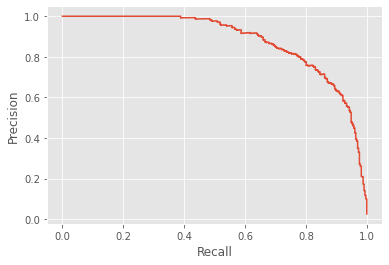

In [21]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### Probability of Machine failure

In [22]:
def prob_failure(machine_id):
    machine_df=df_test[df_test.id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    m_pred=model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

In [23]:
machine_id=16
print('Probability that machine will fail within 30 days: ',prob_failure(machine_id)*100,"%")

Probability that machine will fail within 30 days:  2.409219741821289 %
